In [ ]:
# 1) Setup & Imports
import os # Setup & imports
import random # Thư viện tạo số ngẫu nhiên (phục vụ seed)
import numpy as np 
import torch 
import torch.nn as nn  
import torch.optim as optim
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix, classification_report  # Đánh giá mô hình: ma trận nhầm lẫn và báo cáo phân loại
import seaborn as sns  

In [ ]:
def seed_everything(seed=42):
    random.seed(seed) # Cố định seed cho thư viện random (Python)
    np.random.seed(seed) # NumPy
    torch.manual_seed(seed) # PyTorch (CPU)
    torch.cuda.manual_seed_all(seed) # PyTorch (GPU nếu có)
    torch.backends.cudnn.deterministic = True  # reproducible
    torch.backends.cudnn.benchmark = False # Tắt tối ưu cuDNN để kết quả không thay đổi giữa các lần chạy

seed_everything(42) # Gọi hàm seed để cố định toàn bộ seed về giá trị 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Chọn GPU (cuda) nếu có, nếu không dùng CPU
print("Using device:", device)


Using device: cpu


Train size: 60000 | Test size: 10000


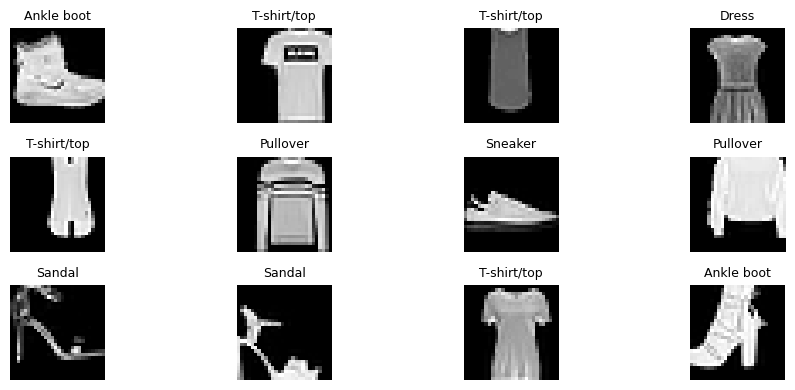

In [ ]:

# 2) Dataset + Data Augmentation
BATCH_SIZE = 128 
DATA_ROOT = "./data" 

# Train transform (augmentation)
train_transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4), # random crop
    transforms.RandomHorizontalFlip(p=0.5),  # flip 50%
    transforms.ToTensor(), # to tensor
    transforms.Normalize((0.5,), (0.5,)) # normalize
])
# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)) 
])
# Load FashionMNIST
train_dataset = datasets.FashionMNIST(DATA_ROOT, train=True, download=True, transform=train_transform)
test_dataset  = datasets.FashionMNIST(DATA_ROOT, train=False, download=True, transform=test_transform) 
#  Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True) 
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True) 
#  Class labels
class_names = [ 
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print("Train size:", len(train_dataset), "| Test size:", len(test_dataset))

# Hiển thị một số ảnh mẫu trong tập train 
def show_samples(dataset, n=12): 
    plt.figure(figsize=(10, 4)) 
    for i in range(n):  
        x, y = dataset[i] 
        plt.subplot(3, 4, i+1)  
        plt.imshow(x.squeeze(0), cmap="gray") 
        plt.title(class_names[y], fontsize=9) 
        plt.axis("off")  
    plt.tight_layout() 
    plt.show() 

show_samples(train_dataset) SS


In [ ]:

# 3) Stronger CNN Model (PRO)
class FashionCNNPro(nn.Module): 
    def __init__(self, num_classes=10): 
        super().__init__() 
       # Conv-BN-ReLU x2 block
        def block(in_ch, out_ch): 
            return nn.Sequential(  
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False), 
                nn.BatchNorm2d(out_ch), 
                nn.ReLU(inplace=True), 
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False), 
                nn.BatchNorm2d(out_ch), 
                nn.ReLU(inplace=True),  
            )

        self.stage1 = block(1, 32) 
        self.pool1  = nn.MaxPool2d(2) # MaxPooling 2x2 giúp giảm kích thước ảnh (28x28 -> 14x14)
        self.drop1  = nn.Dropout2d(0.10) 

        self.stage2 = block(32, 64)  
        self.pool2  = nn.MaxPool2d(2) # MaxPooling 2x2 (14x14 -> 7x7)
        self.drop2  = nn.Dropout2d(0.15)


        self.stage3 = block(64, 128) 
        self.gap    = nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling đưa feature map về kích thước 1x1 (giảm số tham số)
        self.drop3  = nn.Dropout(0.25) 

        self.fc = nn.Linear(128, num_classes) # Fully Connected: ánh xạ 128 đặc trưng cuối -> num_classes (10 lớp)

    def forward(self, x): # xác định luồng dữ liệu đi qua mô hình
        x = self.drop1(self.pool1(self.stage1(x))) 
        x = self.drop2(self.pool2(self.stage2(x))) 
        x = self.stage3(x) 
        x = self.gap(x) 
        x = torch.flatten(x, 1) 
        x = self.drop3(x) 
        x = self.fc(x) 
        return x 

model = FashionCNNPro().to(device)  
print(model) 

criterion = nn.CrossEntropyLoss() 

LR = 1e-3 
WEIGHT_DECAY = 1e-4 
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY) 

EPOCHS = 20 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS) # CosineAnnealingLR: giảm LR từ từ theo dạng cosine trong suốt EPOCHS


FashionCNNPro(
  (stage1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.1, inplace=False)
  (stage2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inp

In [ ]:
# 4) Training + Early Stopping
from time import time  

# Hàm tính accuracy từ logits (tỉ lệ dự đoán đúng)
def accuracy_from_logits(logits, labels):
    preds = logits.argmax(dim=1)  # lấy class có logit lớn nhất
    return (preds == labels).float().mean().item()  # trả về float (ví dụ 0.95 = 95%)

# Chạy 1 epoch huấn luyện (trên một dataloader)
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()  # bật chế độ huấn luyện (BatchNorm/Dropout khác)
    total_loss, total_acc, n = 0.0, 0.0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)  # đưa dữ liệu lên device

        logits = model(images)  # forward
        loss = criterion(logits, labels)  # compute loss
        optimizer.zero_grad()  # reset gradients
        loss.backward()  # backward pass
        optimizer.step()  # update weights

        bs = images.size(0)  # batch size hiện tại
        # cộng dồn loss/acc để tính trung bình theo mẫu (not theo batch)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, labels) * bs
        n += bs

    return total_loss / n, total_acc / n  # trả về (loss trung bình, acc trung bình)


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    # Đánh giá trên toàn bộ loader mà không tính gradient
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)

        bs = images.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_from_logits(logits, labels) * bs
        n += bs

    return total_loss / n, total_acc / n


# Early stopping & checkpoint settings
PATIENCE = 5  # nếu không cải thiện trong PATIENCE epoch -> dừng sớm
best_acc = 0.0  # lưu best accuracy trên tập validation/test
best_path = "best_fashioncnn_pro.pth" 
wait = 0  # số epoch liên tiếp không cải thiện

# Lists để vẽ đồ thị sau khi huấn luyện
train_losses, train_accs = [], []
test_losses, test_accs = [], []

start = time()
for epoch in range(1, EPOCHS + 1):
    # 1) Huấn luyện 1 epoch
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    # 2) Đánh giá trên test set
    te_loss, te_acc = evaluate(model, test_loader, criterion, device)
    # 3) Cập nhật scheduler (nếu có)
    scheduler.step()

    # Lưu lại số liệu để vẽ curve
    train_losses.append(tr_loss); train_accs.append(tr_acc)
    test_losses.append(te_loss);  test_accs.append(te_acc)

    # Nếu test accuracy được cải thiện -> lưu checkpoint tốt nhất
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), best_path)  # lưu state_dict
        wait = 0  # reset counter
    else:
        wait += 1  # tăng counter nếu không cải thiện

    lr_now = optimizer.param_groups[0]["lr"]
    print(f"Epoch {epoch:02d}/{EPOCHS} | lr {lr_now:.6f} | "
          f"Train {tr_loss:.4f}/{tr_acc*100:.2f}% | "
          f"Test {te_loss:.4f}/{te_acc*100:.2f}% | best {best_acc*100:.2f}%")

    # Early stopping khi không cải thiện quá PATIENCE epoch liên tiếp
    if wait >= PATIENCE:
        print(f"Early stopping triggered (no improvement in {PATIENCE} epochs).")
        break

print(f"Done in {time()-start:.1f}s. Best Test Acc = {best_acc*100:.2f}% saved to {best_path}")

c:\Users\dhu17\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/20 | lr 0.000994 | Train 0.7062/74.88% | Test 0.4143/84.83% | best 84.83%
Epoch 02/20 | lr 0.000976 | Train 0.4425/83.64% | Test 0.3591/86.72% | best 86.72%
Epoch 03/20 | lr 0.000946 | Train 0.3807/86.12% | Test 0.2983/89.70% | best 89.70%
Epoch 04/20 | lr 0.000905 | Train 0.3405/87.72% | Test 0.2976/89.29% | best 89.70%
Epoch 05/20 | lr 0.000854 | Train 0.3190/88.35% | Test 0.2709/90.31% | best 90.31%
Epoch 06/20 | lr 0.000794 | Train 0.2979/89.20% | Test 0.2775/90.12% | best 90.31%
Epoch 07/20 | lr 0.000727 | Train 0.2850/89.58% | Test 0.2386/91.44% | best 91.44%
Epoch 08/20 | lr 0.000655 | Train 0.2739/90.08% | Test 0.2521/90.95% | best 91.44%
Epoch 09/20 | lr 0.000578 | Train 0.2597/90.52% | Test 0.2368/91.18% | best 91.44%
Epoch 10/20 | lr 0.000500 | Train 0.2478/91.01% | Test 0.2330/91.88% | best 91.88%
Epoch 11/20 | lr 0.000422 | Train 0.2403/91.25% | Test 0.2163/92.25% | best 92.25%
Epoch 12/20 | lr 0.000345 | Train 0.2365/91.39% | Test 0.2080/92.62% | best 92.62%
Epoc

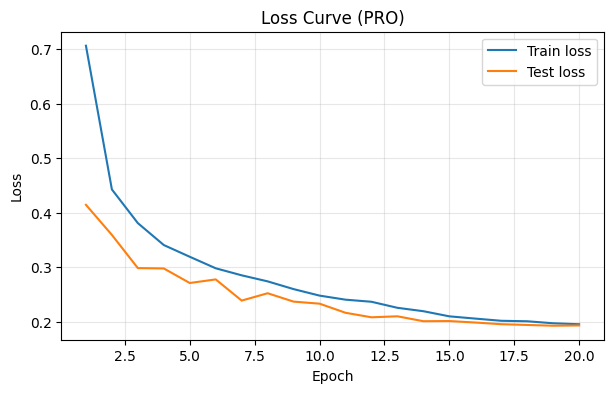

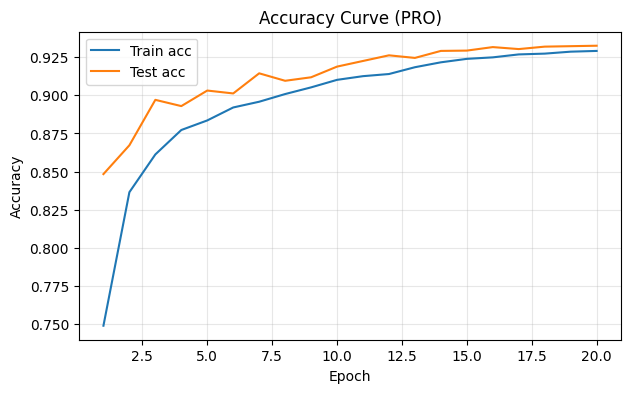

In [ ]:
# 5) Curves: Loss & Accuracy
# Vẽ đồ thị loss & accuracy để đánh giá quá trình huấn luyện (kiểm tra overfitting/underfitting)

epochs_ran = len(train_losses)  # số epoch đã chạy
x = np.arange(1, epochs_ran + 1)  # trục x: epoch số

# Loss curve
plt.figure(figsize=(7,4))
plt.plot(x, train_losses, label="Train loss")
plt.plot(x, test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve (PRO)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Accuracy curve
plt.figure(figsize=(7,4))
plt.plot(x, train_accs, label="Train acc")
plt.plot(x, test_accs, label="Test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve (PRO)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Classification Report (Test):
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.89      0.88      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.90      0.92      0.91      1000
       Dress       0.93      0.92      0.93      1000
        Coat       0.90      0.91      0.90      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.81      0.79      0.80      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



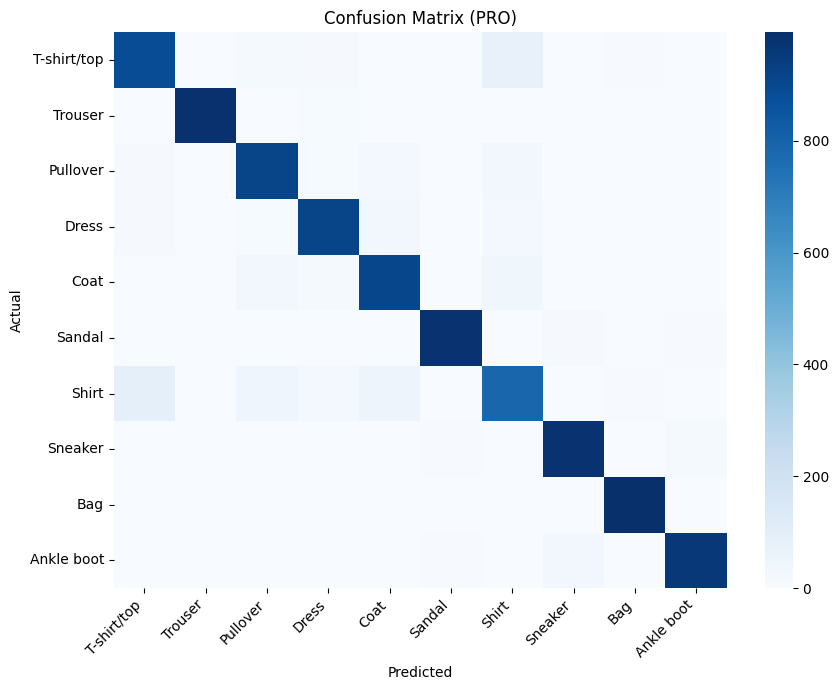

In [ ]:
# 6) Detailed Evaluation (Best Checkpoint)

# Tải lại mô hình tốt nhất đã lưu trong quá trình huấn luyện
best_model = FashionCNNPro().to(device)
best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()

# Thu thập dự đoán và nhãn thực trên toàn bộ test set
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        logits = best_model(images.to(device))
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

# Ghép mảng con lại thành 1 mảng dài
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# In báo cáo phân loại (precision / recall / f1 / support)
print("Classification Report (Test):")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Ma trận nhầm lẫn giúp nhìn rõ các cặp lớp hay bị nhầm lẫn với nhau
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix (PRO)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

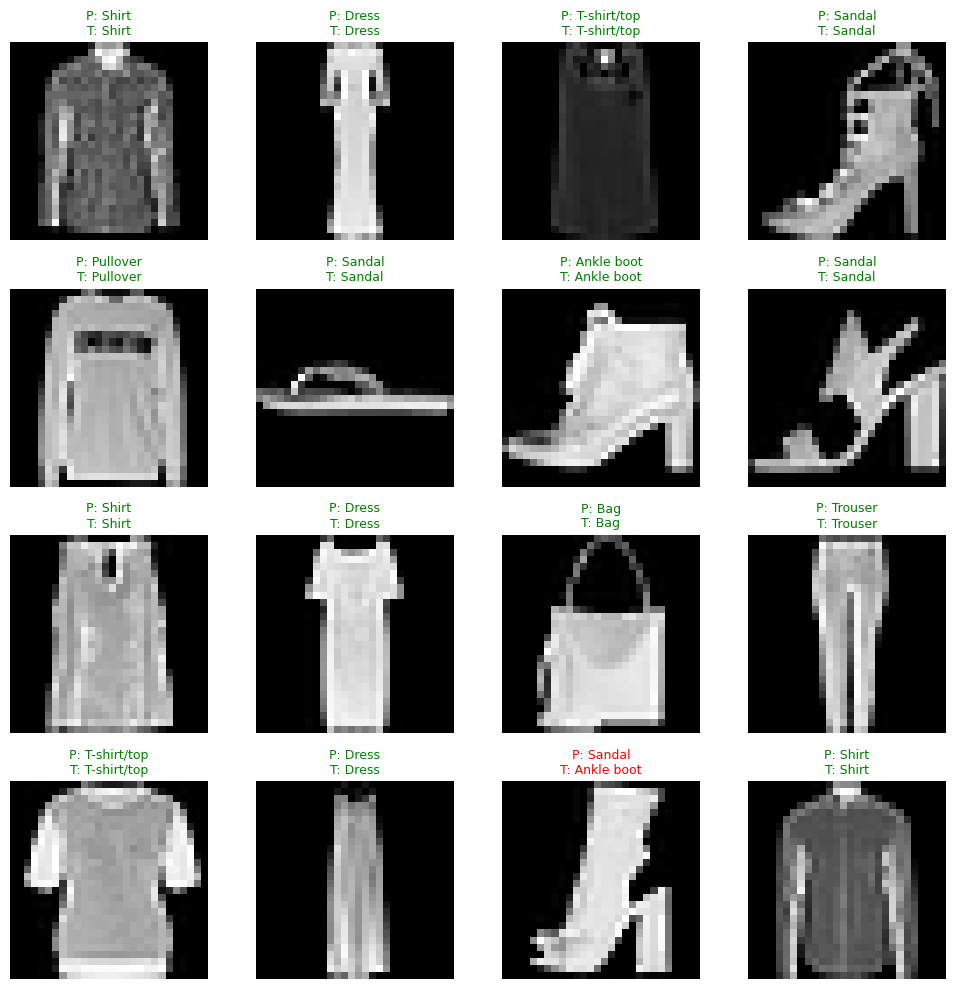

In [ ]:
# 7) Predicted vs Actual Visualization

@torch.no_grad()
def show_predictions(model, dataset, n=16):
    """Hiển thị n mẫu ngẫu nhiên từ dataset, với tiêu đề hiển thị label dự đoán (P) và label thật (T).
    Tiêu đề màu xanh nếu dự đoán đúng, đỏ nếu sai."""
    model.eval()  # chế độ đánh giá
    idxs = np.random.choice(len(dataset), n, replace=False)  # chọn ngẫu nhiên n chỉ số

    plt.figure(figsize=(10,10))
    for i, idx in enumerate(idxs):
        x, y = dataset[idx]  # x: ảnh, y: nhãn thật
        logits = model(x.unsqueeze(0).to(device))  # thêm batch dim và đoán
        pred = logits.argmax(dim=1).item()

        plt.subplot(4,4,i+1)
        plt.imshow(x.squeeze(0), cmap="gray")
        # màu tiêu đề: xanh nếu đúng, đỏ nếu sai
        color = "green" if pred == y else "red"
        plt.title(f"P: {class_names[pred]}\nT: {class_names[y]}", color=color, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Gọi hàm để hiển thị 16 ảnh từ test set
show_predictions(best_model, test_dataset, n=16)

In [ ]:

# 8) Save & Load (Final)
MODEL_PATH = "fashioncnn_pro_final.pth" # Đặt tên file lưu trọng số mô hình (đuôi .pth)
torch.save(best_model.state_dict(), MODEL_PATH) # Lưu trọng số (state_dict) của mô hình tốt nhất vào file MODEL_PATH
print("Saved to:", MODEL_PATH) 
# Load & evaluate
loaded = FashionCNNPro().to(device) 
loaded.load_state_dict(torch.load(MODEL_PATH, map_location=device)) # Tải trọng số từ file đã lưu vào mô hình (map_location để đúng thiết bị)
loaded.eval()  

loss, acc = evaluate(loaded, test_loader, criterion, device) 
print(f"Loaded model -> Test loss {loss:.4f} | Test acc {acc*100:.2f}%")


Saved to: fashioncnn_pro_final.pth


c:\Users\dhu17\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Loaded model -> Test loss 0.1930 | Test acc 93.25%
